In [1]:
import sys
import os
import pickle
import logging
from imp import reload
import numpy as np
import scipy as sc
import seaborn.apionly as sns
import matplotlib.pyplot as plt
#plt.style.use('papers')
%matplotlib inline
import sklearn.decomposition as skd
import chianti.core as ch
research_root = '/home/wtb2/Documents/'
sys.path.append(os.path.join(research_root,'solarnmf'))
sys.path.append(os.path.join(research_root,'EBTEL_C/bin/'))
sys.path.append(os.path.join(research_root,'EBTEL_analysis/src/'))
import solarnmf as snf
import ebtel_wrapper as ebw
import ebtel_configure as ebc
import em_binner as emb
reload(snf)
reload(emb)

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/anaconda3/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


 found PyQt4 widgets
 using PyQt4 widgets


/opt/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'em_binner' from '/home/wtb2/Documents/EBTEL_analysis/src/em_binner.py'>

# Event Detection in Forward Modeled Light Curves
Use EBTEL to create synthetic light curves and then use NMF to try and detect the number of events in this light curve.

## EBTEL Run
First, run the EBTEL model for a couple of heating events and get a temperature and density profile.

In [5]:
#input dictionary
config_dict = {'usage_option':'dem','rad_option':'rk','dem_option':'new','heat_flux_option':'classical',
              'solver':'euler','ic_mode':'st_eq','print_plasma_params':'True'}
config_dict['total_time'] = 36000
config_dict['tau'] = 1.0
config_dict['rka_error'] = 1.0e-6
config_dict['index_dem'] = 451
config_dict['sat_limit'] = 1.0/6.0
config_dict['h_back'] = 3.5e-5
config_dict['heating_shape'] = 'triangle'
config_dict['t_start_switch'] = 'file'
config_dict['t_end_switch'] = 'file'
config_dict['T0'] = 1.0e+6
config_dict['n0'] = 1.0e+8
config_dict['t_start'] = 0.0
config_dict['mean_t_start'] = 1000
config_dict['std_t_start'] = 1000
config_dict['amp_switch'] = 'file'
config_dict['amp0'] = 0.001
config_dict['amp1'] = 0.1
config_dict['alpha'] = 2.
config_dict['loop_length'] = 40.0
config_dict['num_events'] = 15
config_dict['t_pulse_half'] = 100
config_dict['h_nano'] = 0.4
config_dict['sample_rate'] = 100
config_dict['output_file'] = os.path.join(research_root,'research_notebook/NMF/ebtel_light_curve_test')
#set custom start, end times and amplitudes
config_dict['start_time_array'] = np.sort(np.random.normal(config_dict['total_time']/2.,config_dict['total_time']/8.,
                                                  config_dict['num_events']))
config_dict['end_time_array'] = 2.*config_dict['t_pulse_half'] + config_dict['start_time_array']
_configurer = ebc.Configurer(config_dict,'')
config_dict['amp_array'] = _configurer.power_law_dist(np.random.rand(config_dict['num_events']))

In [6]:
#print input file
ebw.print_xml_config(config_dict,config_file=config_dict['output_file']+'.xml')
#run model
ebw.run_ebtel(os.path.join(research_root,'EBTEL_C/bin/'),'',config_file=config_dict['output_file']+'.xml',verbose=True)

************************************************************************************
            Enthalpy Based Thermal Evolution of Loops (EBTEL)                       
************************************************************************************

Original code written in IDL by J.A. Klimchuk, S. Patsourakos, P.J. Cargill
See Klimchuk, J.A, S. Patsourakos & P.J. Cargill 2008, ApJ 682:1351-2362
See also Cargill, P.J., S.J. Bradshaw & J.A. Klimchuk 2012, ApJ 752:161-174

Translation into the C Programming Language by Will Barnes,
Dept. of Physics & Astronomy, Rice University (2014)
************************************************************************************

INPUTS
------
Total time: 36000 s
Time step: 1.000000 s
Loop half-length: 40.000000 Mm
Usage option(see documentation): dem
Heating pulse shape: triangle
Solving equations using Euler method
Using Raymond-Klimchuk Loss Function
Using classical method to calculate the heat flux
Using new method to calculate DEM in the 

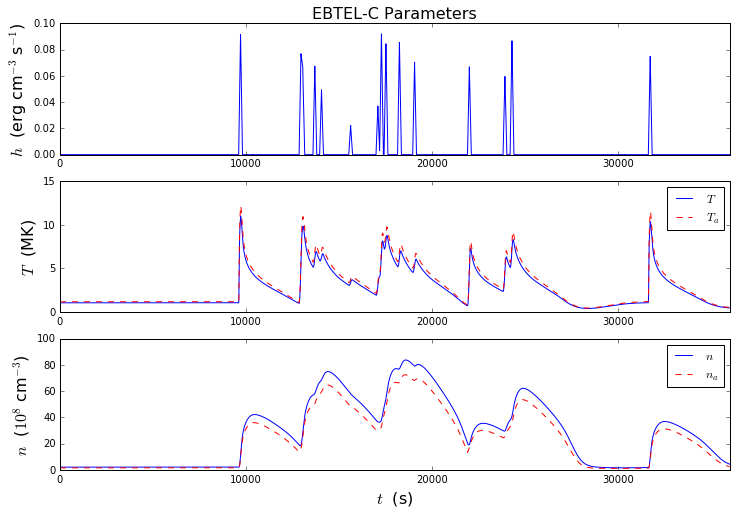

In [7]:
#plot result
ebw.plot_ebtel('',config_dict['output_file']+'.txt')

In [ ]:
#Load data
data = np.loadtxt(config_dict['output_file']+'.txt')
t_ebtel = data[:,0]
T_ebtel = data[:,1]
n_ebtel = data[:,2]

In [ ]:
#interpolate temperature curve
sample_interval = int(config_dict['t_pulse_half'])
t_ebtel_short = t_ebtel[0:-1:sample_interval]
tckT = sc.interpolate.splrep(t_ebtel,T_ebtel)
tckn = sc.interpolate.splrep(t_ebtel,n_ebtel)
T_ebtel_short = sc.interpolate.splev(t_ebtel_short,tckT,der=0)
n_ebtel_short = sc.interpolate.splev(t_ebtel_short,tckn,der=0)

In [ ]:
#test to make sure the interpolation isn't messing things up
plt.plot(t_ebtel,T_ebtel,'k')
plt.plot(t_ebtel_short,T_ebtel_short,'r')
len(T_ebtel_short)

## Forward-modeled Light Curve
Now, we want to use the resulting temperature and density to calculate a light curve.

### Differential Emission Measure, $\mathrm{DEM}(T)$

First, calculate the differential emission measure. Here, we'll only use the coronal component which shouldn't be a problem given the temperatures that we care about.

In [ ]:
binner = emb.EM_Binner(t_ebtel_short,T_ebtel_short,n_ebtel_short,2.0*config_dict['loop_length']*1.e+8)

In [ ]:
binner.build_em_dist()

### Contribution Function, $G(n,T)$
Now we'll use the contribution function as calculated by CHIANTI for Fe XVIII

In [ ]:
fe18 = ch.ion('fe_18',temperature=T_ebtel_short,eDensity=np.mean(n_ebtel_short))

In [ ]:
fe18.popPlot()

In [ ]:
fe18.gofnt(wvlRange=[90,95],top=3)

### Intensity Calculation
First, do some preliminary calculations and allocations.

In [ ]:
T_EM = 10**binner.logT_EM
dlogT = binner.logT_EM[1] - binner.logT_EM[0] #assumes uniform spacing
g = np.zeros(len(T_EM))
g_avg = np.zeros(len(t_ebtel_short))
intensity = np.zeros(len(t_ebtel_short))
intensity_avg = np.zeros(len(t_ebtel_short))

In [ ]:
ind_g = np.where((T_EM > np.min(fe18.Gofnt['temperature'])) & (T_EM < np.max(fe18.Gofnt['temperature'])))
tck_g = sc.interpolate.splrep(np.log10(fe18.Gofnt['temperature']),np.log10(fe18.Gofnt['gofnt']))
g[ind_g] = 10.**(sc.interpolate.splev(binner.logT_EM[ind_g],tck_g,der=0))

Now, loop over time and calculate the intensity according to the $\mathrm{DEM}$.

In [ ]:
for i in range(len(t_ebtel_short)):
    intensity[i] = np.log(10.)*dlogT*np.sum(g*T_EM*binner.dem_mat[i,:])

Next, calculate the average intensity according to the density $n$ and temperature $T$.

In [ ]:
ind_g_avg = np.where((T_ebtel_short > np.min(fe18.Gofnt['temperature'])) & (T_ebtel_short < np.max(fe18.Gofnt['temperature'])))
g_avg[ind_g_avg] = 10.**(sc.interpolate.splev(np.log10(T_ebtel_short[ind_g]),tck_g,der=0))

In [ ]:
intensity_avg = n_ebtel_short**2*g_avg*2.*config_dict['loop_length']*1.e+8

Normalize both intensities.

In [ ]:
intensity = intensity/np.max(intensity)
intensity_avg = intensity_avg/np.max(intensity_avg)

## Plot Intensity

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(14,7),sharex=True)
ax[0].plot(t_ebtel,intensity,linewidth=2)
ax[1].plot(t_ebtel,intensity_avg,linewidth=2)
ax[1].set_xlabel(r'$t$ $\mathrm{(s)}$',fontsize=22)
ax[0].set_ylabel(r'$I$',fontsize=22)
ax[1].set_ylabel(r'$\bar{I}$',fontsize=22)
plt.show()

Let's write these to a file so we dont' necessarily have to go through this calculation again.

In [ ]:
with open('ebtel_lc_test.intensity','wb') as f:
    pickle.dump([t_ebtel,intensity,intensity_avg],f)
f.close()

In [ ]:
with open('ebtel_lc_test.gofnt','wb') as f:
    pickle.dump([fe18.Gofnt['temperature'],fe18.Gofnt['gofnt']],f)
f.close()